In [249]:
from sklearn.datasets import load_iris
import pandas as pd
import torch
import torch.nn as nn
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Load Data and Draw Plots

In [9]:
iris = load_iris()
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df['label'] = iris.target

# 二分类问题，舍弃部分数据
df = df[df['label']!=0]
df['label'][df['label']==2] = -1

In [27]:
df['label'].value_counts()

 1    50
-1    50
Name: label, dtype: int64

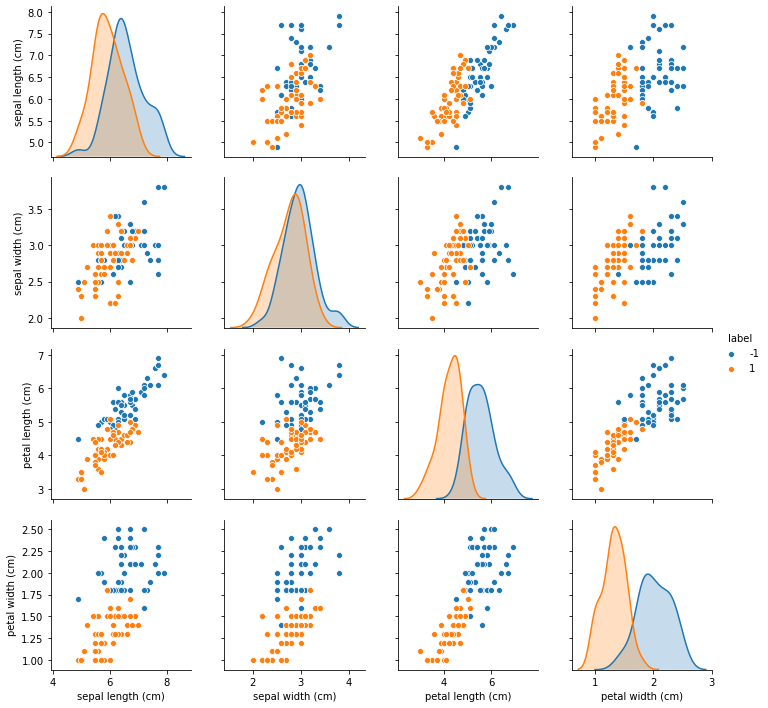

In [10]:
sns.pairplot(data=df, vars=iris.feature_names, hue='label')

In [251]:
# train test  split
msk = np.random.rand(len(df)) < 0.8
train = df[msk]
test = df[~msk]

# Perceptron in Pure Python

In [252]:
class Percepton:
    def __init__(self,X,y,lam):
        self.X = X
        self.y = y
        self.w = [0 for _ in range(len(X[0]))] # 初始参数定为 0
        self.b = 0
        self.lam = lam

    def update_term(self, X_one_point,y_one_point):
        for i in range(len(self.w)):
            self.w[i] += self.lam*y_one_point*X_one_point[i]
        self.b += self.lam*y_one_point

    def classify(self,X_one_point, y_one_point):
        result = 0
        for x,w in zip(X_one_point, self.w):
            result += x*w
        result += self.b
        return y_one_point*result>0 # 返回是否判断正确
    
    def train(self):
        num_iter = 0
        while num_iter < 1000:
            num_misclassified = 0
            for i in range(len(self.X)):
                if self.classify(self.X[i],self.y[i]):
                    continue
                else: #判断错误时
                    num_misclassified += 1
                    self.update_term(self.X[i],self.y[i])
            if num_misclassified == 0:
                break
            num_iter += 1

In [253]:
perceptron = Percepton(X=train.drop('label',axis=1).values, y=train['label'].values,lam=0.1)
perceptron.train()

In [254]:
print(perceptron.w)
print(perceptron.b)

[9.369999999999575, 10.96000000000012, -14.070000000000222, -25.82000000000028]
18.19999999999999


In [255]:
preds = [perceptron.classify(row[1].values[:-1], row[1].values[-1]) for row in test.iterrows()]
print('总准确率： %f' % (sum(preds) / len(preds)))

for y in [-1, 1]:
    preds = [perceptron.classify(row[1].values[:-1], row[1].values[-1]) for row in test[test['label']==y].iterrows()]
    print('label=%i 的准确率： %f' % (y, sum(preds) / len(preds)))

总准确率： 1.000000
label=-1 的准确率： 1.000000
label=1 的准确率： 1.000000


# Perceptron in Pytorch

In [285]:
class Perceptron(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(4, 1)
        self.optimizer = torch.optim.SGD(self.parameters(), lr=0.01)
    
    def forward(self, data):
        return self.fc(data)
    
    def predict(self, data):
        output = self.forward(data)
        ones = torch.ones(output.shape)
        minus_ones = torch.ones(output.shape) * -1
        pred = torch.where(output>0, ones, minus_ones)
        return pred
    
    def criterion(self, output, labels):
        ones = torch.ones(output.shape)
        minus_ones = torch.ones(output.shape) * -1
        pred = torch.where(output>0, ones, minus_ones)
        return torch.sum(output[pred != labels] * labels[pred != labels] * -1)
    
    def fit(self, data, labels, verbose=True, draw_losses=True):
        losses = []
        for t in range(1, 1001):
            output = self.forward(data)
            loss = self.criterion(output, labels)
            
            if verbose and t % 100 == 0:
                print(t, loss.item())
            if t % 10 == 0:
                losses.append(loss.item())

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

        if draw_losses:
            sns.tsplot(data=losses, legend=False)
            plt.show()
        print('Done!')
    
    def accuracy(self, data, labels):
        return sum(self.predict(data) == labels).item() / data.shape[0]

In [286]:
train_data = torch.tensor(train.drop('label',axis=1).values).float()
train_labels = torch.tensor(train['label'].values).float().unsqueeze(1)

test_data = torch.tensor(test.drop('label',axis=1).values).float()
test_labels = torch.tensor(test['label'].values).float().unsqueeze(1)

perceptron = Perceptron()

100 18.909543991088867
200 20.439716339111328
300 22.233613967895508
400 10.051191329956055
500 6.368961334228516
600 4.8001179695129395
700 7.425809860229492
800 6.047914505004883
900 8.359768867492676
1000 6.071826934814453


/Users/bello/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


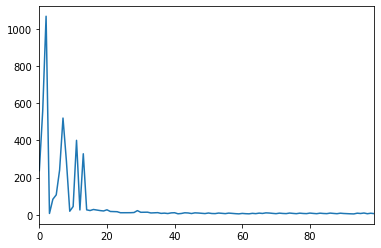

Done!


In [287]:
perceptron.fit(train_data, train_labels)

In [288]:
perceptron.accuracy(test_data, test_labels)

1.0

In [289]:
torch.cuda.is_available()

False